**Plotting Transit Probability Ratios of Consecutive Multiplicity, Averaged Over All Systems Across Time**

This notebook produces plots which show the ratios of the transit probabilities of consecutive multiplicity (`prob(N+1 transits)/prob(N transits)`), averaged across all systems at each timestep.

In [1]:
from generate_lib import *
from types import NoneType
from copy import copy
import pandas as pd

In [2]:
SAVE_PLOTS = True
SHOW_PLOTS = True

In [3]:
def get_prob_ratio_data(systems):
    '''
    Gets the averaged N+1/N transit probabilities over the given list of systems, up to N = 9 planets.

    Params:
    - systems: A list of systems (.csv filenames) from which it pulls data.
    Returns:
    - (time, mean_transit_pair_prob_ratios): A tuple with time series data and the summed probability ratios.
    '''

    # Defines the variables which will hold the important data.
    time = None
    transit_pair_prob_ratios = dict()
    mean_transit_pair_prob_ratios = dict()

    # Sets constants for control and convenience.
    TIME_HEAD = 'Time'
    INTEGRATION_TIME = 1e6
    TIME_STEP = 100

    # Creates a list of every possible header combination ('2 Planets/1 Planets' etc.)
    headers = [(n_planet_prob(planets+1) + '/' + n_planet_prob(planets)) for planets in range(1, 10)]

    # Loops through all the specified systems.
    for system in systems:
        # Accesses the data as a pandas data frame.
        filepath = os.path.join(path, system)
        filedata = pd.read_csv(filepath, index_col = False)

        # Captures the final timestep of the data.
        end_time = filedata[TIME_HEAD].iloc[-1]

        # Checks if the data made it to 1 Myr. If it did not, the code moves to the next system.
        if end_time < INTEGRATION_TIME:
            continue
        elif type(time) == NoneType:
            # Sets the time series data if it has not yet been set. The elif statement ensures that
            # this only happens once and that the time series made it to 1 Myr.
            time = filedata[TIME_HEAD]

        # Planets is a looping counter that goes from 1-9.
        planets = 1

        # Loops through every head in the headers array (2 Planets/1 Planets, 3 Planets/2 Planets, etc.)
        for head in headers:
            # Gets headers for accessing the column data (2 Planets, 1 Planets, etc.)
            (h1, h2) = head.split('/')
            
            # Ensures that the headers exist in the data.
            if h1 not in filedata.columns or h2 not in filedata.columns:
                continue
            
            # Sets each data. Note that n_plus_data should show up in the numerator and n_data in the denominator.
            n_plus_data = filedata[h1].astype(float)
            n_data = filedata[h2].astype(float)

            # Eliminates precision errors and prevents division by zero.
            n_plus_data[n_plus_data == 0.0] = np.nan
            n_data[n_data == 0.0] = np.nan

            # Calculates a series of probability ratios for the given system. Note that this should be a numpy array.
            prob_ratios = (clean_data(n_plus_data) / clean_data(n_data))

            # Checks if the transit_pair_prob_ratios dictionary has the head as a key.
            if head not in transit_pair_prob_ratios:
                # Sets the key pair value to head: list()
                transit_pair_prob_ratios[head] = list()

                # Allocates memory for the probability ratio data (speeds up processing time).
                mean_transit_pair_prob_ratios[head] = np.empty(int(INTEGRATION_TIME/TIME_STEP))

            # Appends the current list of probability ratios to a list.
            transit_pair_prob_ratios[head].append(prob_ratios)
            
            # Increments the planets counter.
            planets += 1

    # Asserts that the keys match between the two main data dictionaries
    assert transit_pair_prob_ratios.keys() == mean_transit_pair_prob_ratios.keys()

    # Loops through the headers of the pair probability ratio dictionary. Note that these keys match those of the
    # mean_transit_pair_prob_ratios via the above assertion.
    for head in transit_pair_prob_ratios:
        # Transposes the array so np.nanmean can be used on each row.
        transposed_data = np.array(transit_pair_prob_ratios[head]).T

        # Loops through the index of each row of the transposed data matrix.
        for row_idx in range(len(transposed_data)):
            # Assigns the row as a variable for easy reading and reference.
            row = transposed_data[row_idx]

            # Sets the pair prob ratio for the given time step (row_idx) to the mean value (ignoring np.nan values) across all
            # values of the given head.
            mean_transit_pair_prob_ratios[head][row_idx] = np.nanmean(row)

    # Returns the data.
    return (time, mean_transit_pair_prob_ratios)

In [4]:
files = copy(data_files)
rfiles = []

unstable_systems = ['sysSim_88.csv']

# Backwards iteration.
for idx in range(len(files)-1, -1, -1):
    filename = files[idx]

    if filename in unstable_systems:
        continue

    suffix = '_randomO'

    if suffix in filename:
        files.pop(idx)
        rfiles.append(filename)

(time, avg_probs) = get_prob_ratio_data(files)
(time, ravg_probs) = get_prob_ratio_data(rfiles)

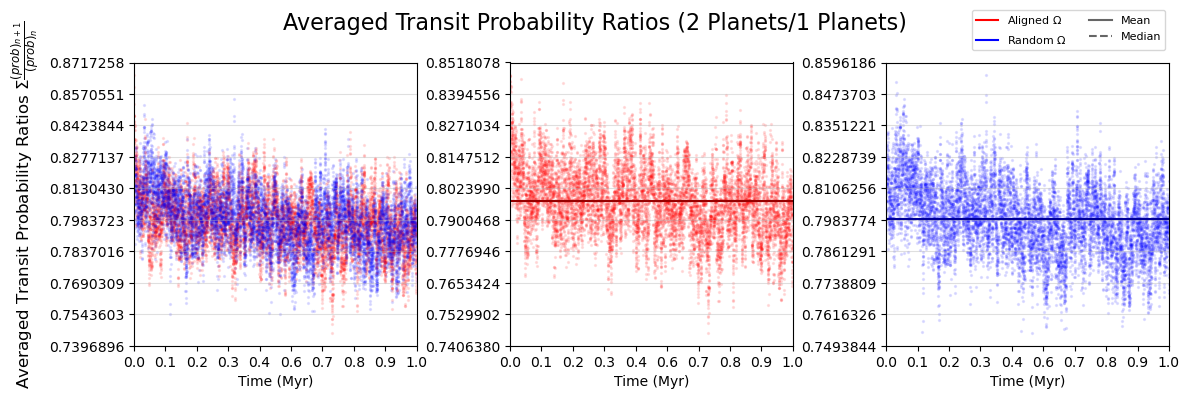

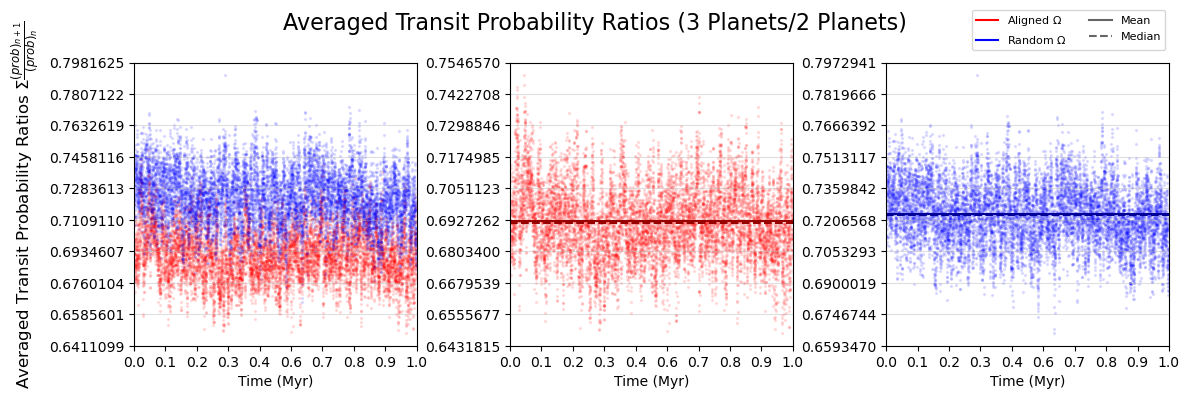

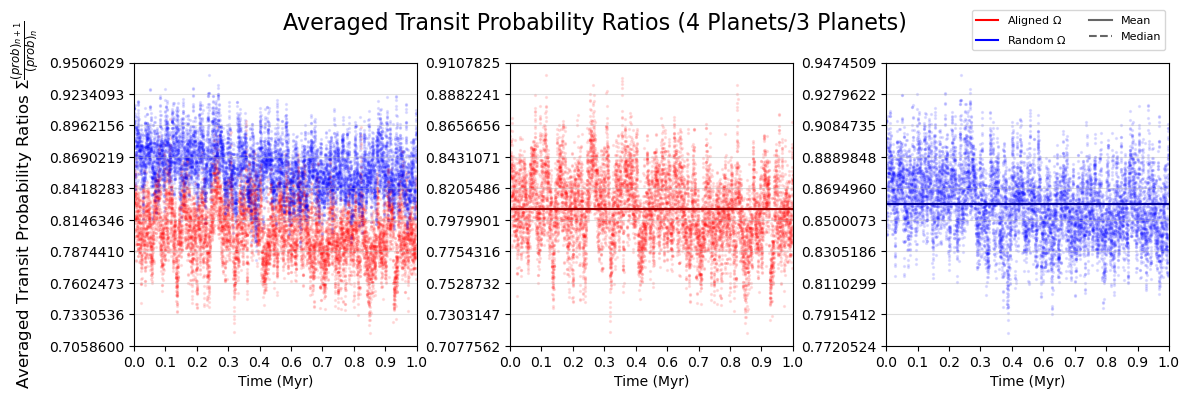

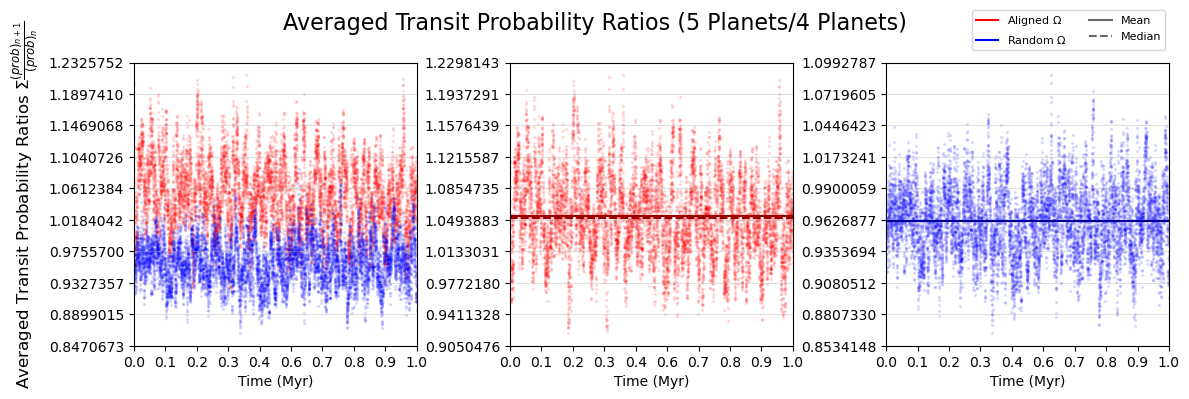

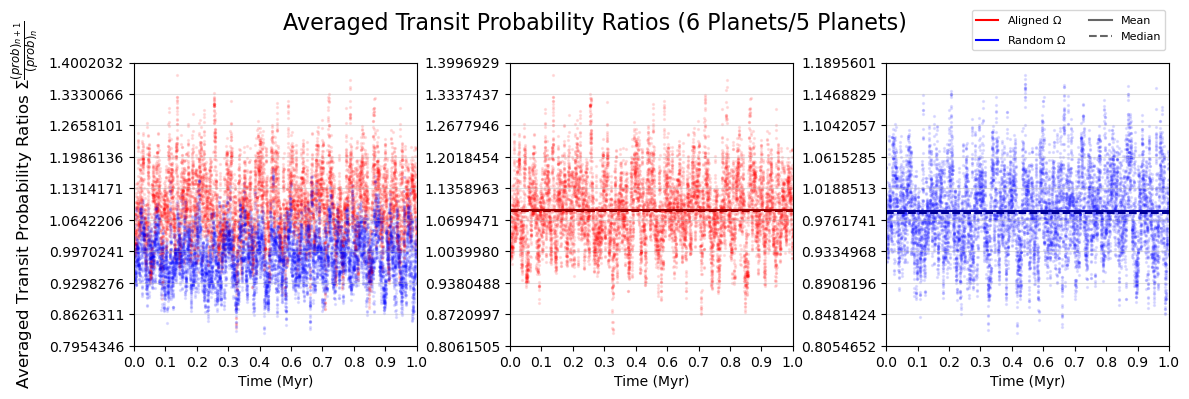

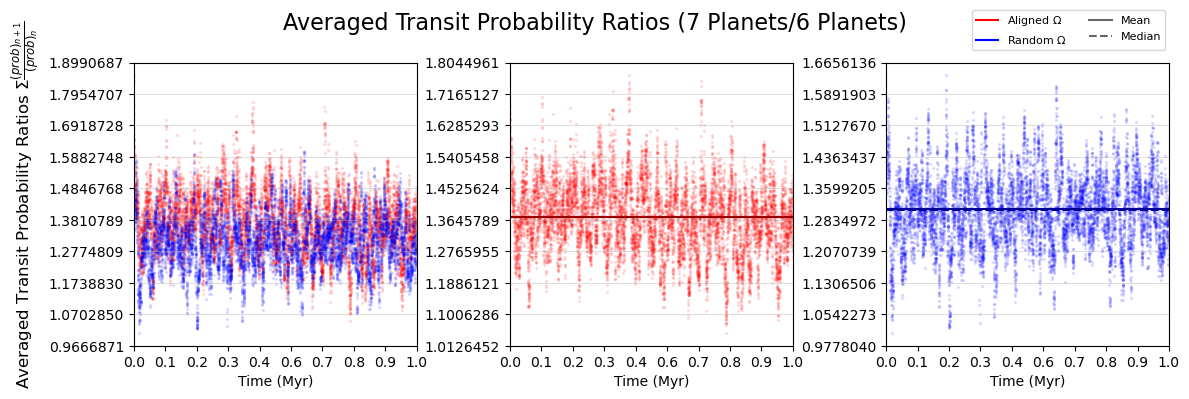

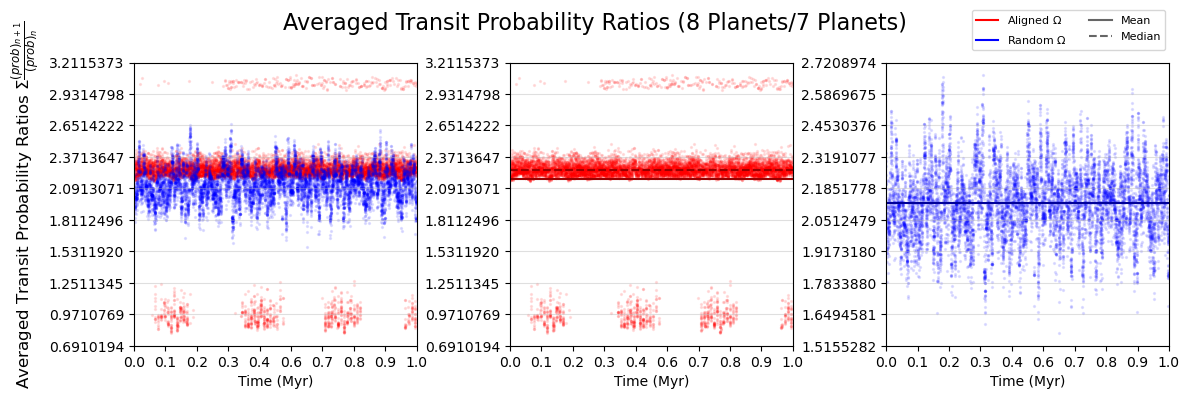

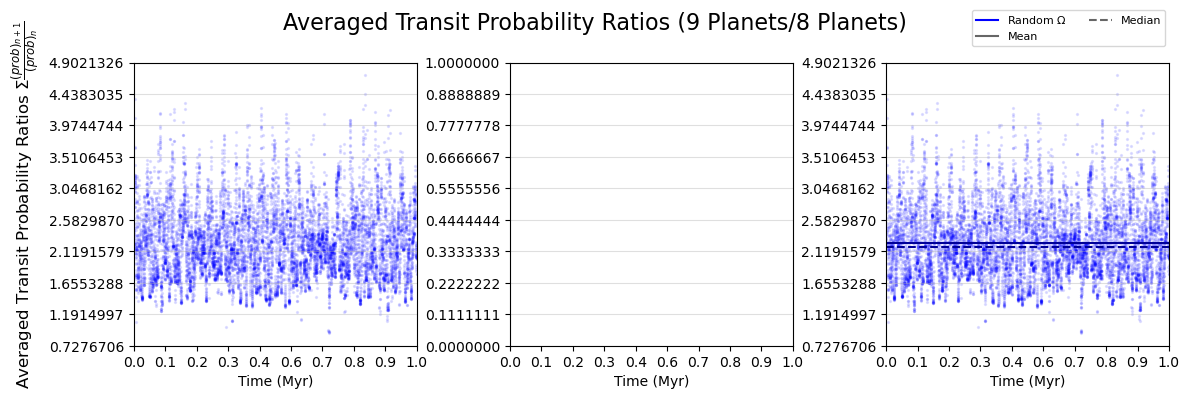

In [5]:
for n in range(1, 9):
    (fig, axes) = plt.subplots(1, 3, sharey = False)
    fig.set_size_inches(12, 4)

    head = n_planet_prob(n+1) + '/' + n_planet_prob(n)

    (x, y) = (time[2:], avg_probs[head][2:]) if head in avg_probs else (None, None)
    (rx, ry) = (time[2:], ravg_probs[head][2:]) if head in ravg_probs else (None, None)

    # Panel 1.
    plt.subplot(1, 3, 1)

    if head in avg_probs:
        plt.scatter(x, y, s=2, color = 'red', alpha = 0.1)

        # Legend label.
        plt.plot([], [], color = 'red', label = 'Aligned $\Omega$')
    
    if head in ravg_probs:
        plt.scatter(rx, ry, s=2, color = 'blue', alpha = 0.1)

        # Legend label.
        plt.plot([], [], color = 'blue', label = 'Random $\Omega$')

    plt.plot([], [], color = (0.4, 0.4, 0.4), label = 'Mean')
    plt.plot([], [], color = (0.4, 0.4, 0.4), label = 'Median', linestyle = 'dashed')

    # Panel 2.
    plt.subplot(1, 3, 2)
    
    if head in avg_probs:
        plt.scatter(x[4:], y[4:], s=2, color = 'red', alpha = 0.1)

        mean = np.nanmean(y)
        median = np.nanmedian(y)

        plt.hlines(mean, 0, 1e6, color = (0.6, 0.0, 0.0))
        plt.hlines(median, 0, 1e6, color = (0.6, 0.0, 0.0), linestyles = 'dashed')

    # Panel 3.
    plt.subplot(1, 3, 3)

    if head in ravg_probs:
        plt.scatter(rx, ry, s=2, color = 'blue', alpha = 0.1)

        rmean = np.nanmean(ry)
        rmedian = np.nanmedian(ry)

        plt.hlines(rmean, 0, 1e6, color = (0.0, 0.0, 0.6))
        plt.hlines(rmedian, 0, 1e6, color = (0.0, 0.0, 0.6), linestyles = 'dashed')

    for col in range(len(axes)):
        ax = axes[col]

        ax.grid(True, axis = 'y', alpha = 0.4)

        ax.set_xlim(0, 1e6)
        ax.xaxis.set_major_locator(tck.LinearLocator(10))
        ax.xaxis.set_major_formatter(tck.FuncFormatter(lambda x, pos: '%.1f' % (x/1e6)))
        ax.yaxis.set_major_formatter(tck.FuncFormatter(lambda x, pos: '%.7f' % x))
        ax.yaxis.set_major_locator(tck.LinearLocator(10))

        if col == 0:
            ax.set_ylabel('Averaged Transit Probability Ratios $\Sigma \\frac{(\mathit{prob})_{n+1}}{(\mathit{prob})_{n}}$', fontsize = 12)
        
        ax.xaxis.set_major_formatter(tck.FuncFormatter(lambda x, pos: '%.1f' % (x/1e6)))
        ax.set_xlabel('Time (Myr)', fontsize = 10)

    # Titles the figure.
    fig.suptitle('Averaged Transit Probability Ratios ({head})'.format(head = head), fontsize = 16)
    fig.tight_layout()

    fig.subplots_adjust(wspace = 0.33, hspace = 0.3)
    fig.legend(bbox_to_anchor = (0.98, 1), ncols = 2, fontsize = 8)

    if SAVE_PLOTS:
        savepath = os.path.join(os.pardir, os.pardir, 'results', 'avg_prob_ratios', 'avg_prob_ratios_' + head.replace('/', '_').replace(' ', '_'))
        fig.savefig(savepath, dpi = 300, bbox_inches = 'tight')

if SHOW_PLOTS:
    plt.show()